In [88]:
%pylab inline

import pandas as pd
import corona
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [146]:
from importlib import reload
reload(corona)

<module 'corona' from '/Users/isaacdrachman/GitHub/ML-Projects/corona.py'>

# Kaggle COVID-19 Chest X-Ray Challenge 
Dataset from https://www.kaggle.com/c/csc532/data

Images classified as either "Normal" or "Pneumonia", with pnemonia cases further specified as below.

In [22]:
pd.read_csv('./coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv',index_col=0)

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [154]:
# Set up datasets and nn model. 
# The data files are structured in folders "bacteria", "virus", and "normal". 
# I use the torchvision dataset class ImageFolder which auto-labels the data accordingly.
loaders = corona.setup()
model = corona.Model()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(loaders['train'].dataset.dataset.class_to_idx)
idx_to_class = {idx: class_ for class_, idx in loaders['train'].dataset.dataset.class_to_idx.items()}

{'bacteria': 0, 'normal': 1, 'viral': 2}


In [149]:
# Label distribution for train set:
targets = []
for _, target in loaders['train']:
    targets += target
counts = np.unique(targets, return_counts=True)
print('train',counts[0],counts[1]/counts[1].sum())

train [0 1 2] [0.46992187 0.25039062 0.2796875 ]


target: viral (2)


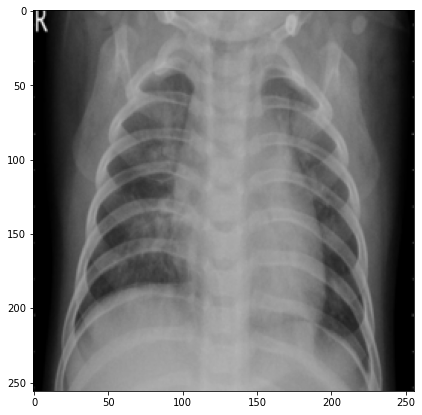

In [150]:
# Example image.
figsize(7,7)
example = loaders['train'].dataset[0]

imshow(example[0].reshape(256,256,3))
print('target: {} ({:d})'.format(idx_to_class[example[1]], example[1]))

In [157]:
# Start training! Prints stats every 20 batches and runs validation / saves model every epoch.
model, losses, accuracies = corona.train_many(10, model, optimizer, loaders['train'], loaders['test'])

[1 /10][1344/2560 ( 5%)]	Loss: 0.625319
[1 /10]	 Accuracy: 72.00%
[2 /10][1344/2560 (15%)]	Loss: 0.473812
[2 /10]	 Accuracy: 76.00%
[3 /10][1344/2560 (25%)]	Loss: 0.415251
[3 /10]	 Accuracy: 76.00%
[4 /10][1344/2560 (35%)]	Loss: 0.360694
[4 /10]	 Accuracy: 72.00%
[5 /10][1344/2560 (45%)]	Loss: 0.477248
[5 /10]	 Accuracy: 76.00%
[6 /10][1344/2560 (55%)]	Loss: 0.323222
[6 /10]	 Accuracy: 74.00%
[7 /10][1344/2560 (65%)]	Loss: 0.600206
[7 /10]	 Accuracy: 73.00%
[8 /10][1344/2560 (75%)]	Loss: 0.319687
[8 /10]	 Accuracy: 76.00%
[9 /10][1344/2560 (85%)]	Loss: 0.371338
[9 /10]	 Accuracy: 79.00%
[10/10][1344/2560 (95%)]	Loss: 0.363653
[10/10]	 Accuracy: 75.00%


## Results
The confusion matrix shows the model has high accuracy at recognizing pnemonia generally, even when it mis-classifies on viral vs. bacterial. 

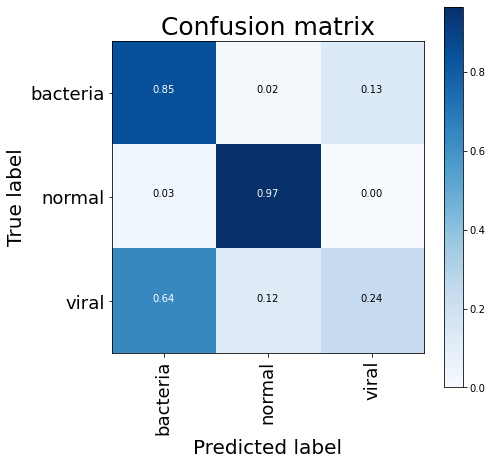

In [158]:
# Evaluate on a random sample from the test set.
sample = corona.get_sample(loaders['test'])
cnf_matrix = confusion_matrix(sample[1], model(sample[0]).argmax(axis=1))
corona.plot_confusion_matrix(cnf_matrix, loaders['train'].dataset.dataset.classes)